In [334]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Load RRR counts from file**

In [335]:
n=10
m=50
RRR_raw = np.loadtxt('/mnt/store1/oliverphilcox/TripleCounts/RRR_counts_n%d_m%d_full.txt'%(n,m))
mu_all = np.arange(1./(2.*m),1.,1./m)

In [336]:
tmp_RRR_counts = np.zeros([n*n,m])
for i in range(m):
    tmp_RRR_counts[:,i]=RRR_raw[i::m]

In [337]:
## Symmetrize
RRR_counts = np.zeros_like(tmp_RRR_counts)
for i in range(n):
    for j in range(n):
        RRR_counts[i*n+j,:]=0.5*(tmp_RRR_counts[i*n+j,:]+tmp_RRR_counts[j*n+i,:])

In [338]:
square_RRR = np.zeros([m,n,n])
for i in range(m):
    for j in range(n):
        square_RRR[i,j,:]=RRR_counts[j::n,i]

**Combine into Legendre Multipoles for viewing**

In [339]:
from scipy.special import legendre
max_l = 8
RRR_legendre = np.zeros([max_l,n*n])
for ell in np.arange(0,max_l+2,2):
    RRR_legendre[ell//2,:]=np.sum(RRR_counts[:,:]*legendre(ell)(mu_all),axis=1)*(mu_all[1]-mu_all[0])*(2.*ell+1.)
RRR_square = np.zeros([max_l,n,n])
for l_i in range(max_l//2+1):
    for i in range(n):
        RRR_square[l_i,i]=RRR_legendre[l_i,i::n]

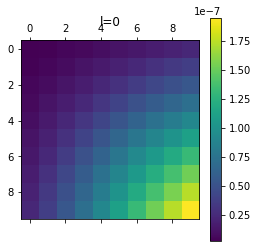

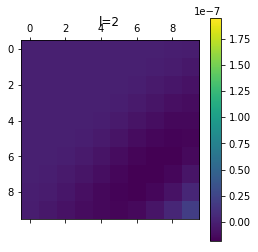

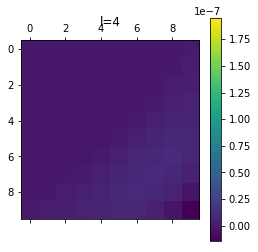

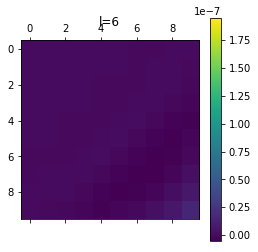

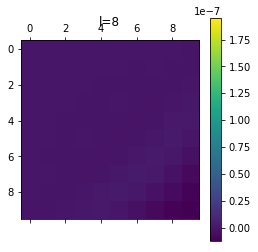

In [340]:
vmax = max(RRR_square.ravel())
for i in range(max_l//2+1):
    plt.matshow(RRR_square[i],vmax=vmax)
    plt.title("l=%d"%(i*2))
    plt.colorbar();

**Compute Correction Function**

In [341]:
### Function to fit a model to the survey correction function, defined as the ratio between model and true RRR triple counts.
## This fits a piecewise polynomial model to the data.

import sys
import numpy as np
import scipy.spatial as ss
from scipy.optimize import curve_fit

gal_file = '/mnt/store1/oliverphilcox/Legendre2PCF/qpm_galaxy_1.xyzwj'
binfile = '/mnt/store1/oliverphilcox/3PCF/3pcf_binfile_cov.csv'
outdir='/mnt/store1/oliverphilcox/3PCF/'


In [342]:
## Load galaxies
print("\nLoading galaxies")
all_gal = np.loadtxt(gal_file)
gal_x = all_gal[:,0]
gal_y = all_gal[:,1]
gal_z = all_gal[:,2]
gal_w = all_gal[:,3]

N_gal = len(all_gal)
w_bar = np.mean(gal_w)

## Find survey volume via ConvexHull in Scipy
hull = ss.ConvexHull(np.vstack([gal_x,gal_y,gal_z]).T)
print('\nSurvey volume is approximately: %.2f (Gpc/h)^3'%(hull.volume/1e9))
V=hull.volume # in (Mpc/h)^3

## Galaxy number density
n_bar = N_gal/V


# Load in binning files 
r_bins = np.loadtxt(binfile)
n=len(r_bins)


Loading galaxies

Survey volume is approximately: 4.04 (Gpc/h)^3


In [343]:
norm_RRR = RRR_counts*np.sum(gal_w)**3. # change normalization

In [344]:
# Find binning centers
r_cen = np.mean(r_bins,axis=1)
delta_r = r_cen[-1]-r_cen[-2]
mu_cen = np.arange(1/(2*m),1.+1/(2*m),1/m)
delta_mu = mu_cen[-1]-mu_cen[-2]
assert(m==len(mu_cen))

## Define normalization constant
norm = 6.*V*(n_bar*w_bar)**3.*(4.*np.pi)**2.

## Define RRR model
def RRR_model(r_cen1,r_cen2,mu):
    return norm*(r_cen1*r_cen2*delta_r)**2.*delta_mu

# Compute correction functions
Phi_values = []
for r_bin1 in range(n):
    for r_bin2 in range(n):
        Phi_values.append(RRR_model(r_cen[r_bin1],r_cen[r_bin2],mu_cen)/norm_RRR[r_bin1*n+r_bin2,:])
Phi_values = np.asarray(Phi_values)

In [345]:
## check for order of magnitude consistency
if np.mean(Phi_values)>10:
    raise Exception("RR_true seems to be much smaller than RR_model. Is the input RR correctly normalized?")
if np.mean(Phi_values)<0.1:
    raise Exception("RR_true seems to be much larger than RR_model. Is the input RR correctly normalized?")

In [346]:
mean_phi = np.mean(Phi_values,axis=1)
square_phi = np.zeros([n,n])
for i in range(n): 
    square_phi[i,:]=mean_phi[i::n]

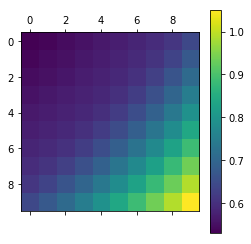

In [347]:
plt.matshow(square_phi);plt.colorbar();

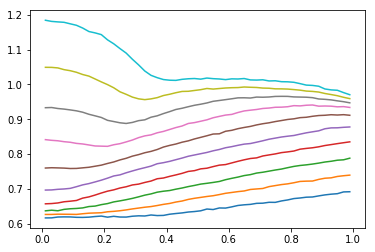

In [357]:
plt.plot(mu_cen,Phi_values[90:].T);

In [376]:
## Define Phi model (piecewise continuous polynomial)
mu_crit=0.75
def Phi_model(mu,*p):
    return p[0]+p[1]*mu+p[2]*mu**2.+p[3]*mu**3.+p[4]*mu**4.+p[5]*mu**5.+p[6]*mu**6.

## Find optimal parameters
fit_params=[]
errors=[]
for i in range(n):
    for j in range(n):
        good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[i*n+j],p0=[0,0,0,0,0,0,0])
        fit_params.append(good_param)
        errors.append(np.abs(Phi_values[i*n+j]-fit_model(mu_cen,good_param))/Phi_model(mu_cen,*good_param))

fit_params = np.asarray(fit_params)

print("\nFitted with mean fractional error %.1e"%np.mean(errors))

outfile = outdir+'SurveyCorrectionFactor_3PCF_n%d_m%d_11.txt'%(n,m)
with open(outfile,"w+") as out:
    for i in range(n):
        for i2 in range(n):
            for j in range(len(fit_params[0])):
                out.write("%.8e"%(fit_params[i*n+i2,j]/norm))
                if j<len(fit_params[0])-1:
                    out.write("\t")
                else:
                    out.write("\n")     
print("\nSaved (normalized) output to %s\n"%outfile)


Fitted with mean fractional error 1.0e-03

Saved (normalized) output to /mnt/store1/oliverphilcox/3PCF/SurveyCorrectionFactor_3PCF_n10_m50_11.txt



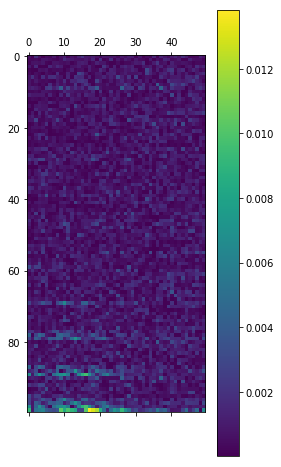

In [377]:
plt.matshow(errors);plt.colorbar();